<a href="https://colab.research.google.com/github/arjan-hada/fastai/blob/master/fastai_Learner_from_scratch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Implementation of fastai Learner from scratch

In this notebook, we will build a fastai Learner from scratch and apply it for classification of letters 3 and 7 from a sample of MNIST dataset.

## 1 - Packages

Let's first import all the packages we will need for this assignment.

In [1]:
#hide
!pip install -Uqq fastbook
import fastbook
fastbook.setup_book()

In [2]:
#hide
from fastai.vision.all import *
from fastbook import *
matplotlib.rc('image', cmap='Greys')

## 2 - Preparing the dataset

### Download the dataset

Download a sample of MNIST dataset that contain images of 3s and 7s.

In [3]:
path = untar_data(URLs.MNIST_SAMPLE)

Peek inside directory using fastai ls() method.


In [4]:
path.ls()

(#3) [Path('/root/.fastai/data/mnist_sample/train'),Path('/root/.fastai/data/mnist_sample/labels.csv'),Path('/root/.fastai/data/mnist_sample/valid')]

Peek inside the train folder.

In [5]:
(path/'train').ls()

(#2) [Path('/root/.fastai/data/mnist_sample/train/3'),Path('/root/.fastai/data/mnist_sample/train/7')]

Peek inside the train folder's 3s and 7s.

In [6]:
threes = (path/'train'/'3').ls().sorted()
sevens = (path/'train'/'7').ls().sorted()

### Image to tensors

Open the images using Image class is from Python Imaging Library (PIL). Create a tensor containing all the images in a directory.

In [7]:
three_tensors = [tensor(Image.open(o)) for o in threes]
seven_tensors = [tensor(Image.open(o)) for o in sevens]

len(three_tensors), len(seven_tensors)

(6131, 6265)

Check one of the image. Use fastai's show_image function to display tensor as image. Each element of the lists - three_tensors or seven_tensors is 28x28.

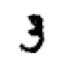

In [8]:
show_image(three_tensors[0]);

Combine all the images in the list into a single rank-3 tensor. Normalize the pixel values to be between 0 and 1.

In [9]:
stacked_threes = torch.stack(three_tensors).float()/255
stacked_sevens = torch.stack(seven_tensors).float()/255
stacked_threes.shape

torch.Size([6131, 28, 28])

### Training and Validation Dataset

Concatenate all the independent variable the images themselves into a single tensor. Technically speaking, change from a list of matrices to a list of vectors or change from a rank-3 tensor to a rank-2 tensor.


In [10]:
train_x = torch.cat([stacked_threes, stacked_sevens]).view(-1, 28*28)

Code dependent variable for each image - 1 for 3s and 0 for 7s.

In [11]:
train_y = tensor([1]*len(threes) + [0]*len(sevens)).unsqueeze(1)
train_x.shape, train_y.shape

(torch.Size([12396, 784]), torch.Size([12396, 1]))

A dataset in Pytorch is required to return a tuple of (x,y) when indexed.

In [12]:
dset = list(zip(train_x, train_y))
x, y = dset[0]
x.shape, y

(torch.Size([784]), tensor([1]))

Let's do the same for validation dataset.

In [13]:
# Create a tensor containing all the images in validation folder
# Combine all the images in the list into a single rank-3 tensor
# Normalize the pixel values between 0 and 1
valid_3_tens = torch.stack([tensor(Image.open(o)) 
  for o in (path/'valid/3').ls()])
valid_3_tens = valid_3_tens.float()/255
valid_7_tens = torch.stack([tensor(Image.open(o)) 
  for o in (path/'valid/7').ls()])
valid_7_tens = valid_7_tens.float()/255

In [14]:
# Create a validation dataset
valid_x = torch.cat([valid_3_tens, valid_7_tens]).view(-1, 28*28)
valid_y = tensor([1]*len(valid_3_tens) + [0]*len(valid_7_tens)).unsqueeze(1)

# A dataset in Pytorch is required to create a tuple of (x,y) when indexed
valid_dset = list(zip(valid_x, valid_y)) 

## 3 - Creating the DataLoader object

Create a DataLoader object for train set. A DataLoader can take any Python collection and turn it into an iterator many batches. A pytorch neural network expects the data to come in the form of minibatches of tensors.



In [15]:
dl = DataLoader(dset, batch_size=256)
xb,yb = first(dl)
xb.shape,yb.shape

(torch.Size([256, 784]), torch.Size([256, 1]))

Create a DataLoader object for validation set.

In [16]:
valid_dl = DataLoader(valid_dset, batch_size=256)

Create a DataLoaders, by passing our training and validation DataLoaders.

In [17]:
dls = DataLoaders(dl, valid_dl)

## 4 - End-to-end Stochastic Gradient Descent

Implementation of Learner from scratch.

In [18]:
def init_params(size, std=1.0):
  return (torch.randn(size)*std).requires_grad_()

def linear1(xb): return xb@weights + bias

def mnist_loss(predictions, targets):
  predictions = predictions.sigmoid()
  return torch.where(targets==1, 1-predictions, predictions).mean()

def batch_accuracy(xb, yb):
  preds = xb.sigmoid()
  correct = (preds>0.5) == yb
  return correct.float().mean()

class BasicOptim:
  def __init__(self, params, lr): self.params, self.lr = list(params), lr

  def step(self, *args, **kwargs):
    for p in self.params:
      p.data -= p.grad.data*self.lr
  
  def zero_grad(self, *args, **kwargs):
    for p in self.params: p.grad = None

def train_model(model, epochs):
  results = defaultdict(list)
  for i in range(epochs):

    train_epoch_loss = []
    # Training epoch
    for xb,yb in dl: # Forward propagation
      preds = model(xb)
      loss = mnist_loss(preds, yb)
      train_epoch_loss.append(loss)
      loss.backward() # Backward propagation or Calculate gradient of the loss function
      opt.step() # Update parameters
      opt.zero_grad()

    accs = []
    valid_epoch_loss = []
    # Validation epoch
    for xb, yb in valid_dl:
      preds = model(xb)
      loss = mnist_loss(preds, yb)
      valid_epoch_loss.append(loss)
      accs.append(batch_accuracy(preds, yb))
      

    results['epoch'].append(i)
    results['train_loss'].append(
        round(torch.stack(train_epoch_loss).mean().item(), 4))
    results['valid_loss'].append(
        round(torch.stack(valid_epoch_loss).mean().item(), 4))
    results['batch_accuracy'].append(round(torch.stack(accs).mean().item(), 4))
  return pd.DataFrame.from_dict(results)

In [22]:
# Initialize the parameters and train
weights = init_params((28*28, 1))
bias = init_params(1)
params = weights, bias
lr = 1

linear_model = linear1
opt = BasicOptim(params, lr)
train_model(linear_model, 10)

,epoch,train_loss,valid_loss,batch_accuracy
0,0,0.1791,0.3488,0.6468
1,1,0.1094,0.1773,0.8270
2,2,0.0743,0.1059,0.8997
3,3,0.0605,0.0788,0.9227
4,4,0.0523,0.0634,0.9403
5,5,0.0473,0.0541,0.9501
6,6,0.0433,0.0483,0.9540
7,7,0.0400,0.0443,0.9569
8,8,0.0371,0.0413,0.9579
9,9,0.0349,0.0388,0.9623


Compare the result of our implementation from fastai's Learner object

In [23]:
learn = Learner(dls, nn.Linear(28*28, 1), opt_func=SGD, 
                loss_func=mnist_loss, metrics=batch_accuracy)
learn.fit(10, 1)

epoch,train_loss,valid_loss,batch_accuracy,time
0,0.637359,0.503291,0.495584,00:00
1,0.465036,0.246566,0.779686,00:00
2,0.173200,0.160938,0.854760,00:00
3,0.076995,0.100013,0.915604,00:00
4,0.041545,0.074687,0.934740,00:00
5,0.027667,0.060542,0.948970,00:00
6,0.021943,0.051562,0.956820,00:00
7,0.019379,0.045523,0.963199,00:00
8,0.018064,0.041255,0.965653,00:00
9,0.017261,0.038099,0.966634,00:00
